In [76]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


    matrixprofile (>=1.1.10<2.0.0)
                  ~~~~~~~~~^


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import math
from xgboost import plot_importance,plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [2]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [3]:
df = pd.read_csv('df_eng_2.csv',index_col='data_hora',parse_dates=True)
df =df.asfreq('W')

In [4]:
df = df.drop(['Pto Orvalho Ins. (C)', 'Pto Orvalho Max. (C)', 'Pto Orvalho Min. (C)','Chuva (mm)'],axis=1)

In [5]:
df = df.drop(['Umi. Max. (%)', 'Pressao Ins. (hPa)',
       'Pressao Max. (hPa)', 'Pressao Min. (hPa)','Raj. Vento (m/s)','Dir. Vento (m/s)'],axis=1)

In [6]:
df.columns

Index(['Unnamed: 0', 'Temp. Ins. (C)', 'Temp. Max. (C)', 'Temp. Min. (C)',
       'Umi. Ins. (%)', 'Umi. Min. (%)', 'Vel. Vento (m/s)',
       'Radiacao (KJ/m²)', 'Mes', 'Ano'],
      dtype='object')

In [7]:
# Reordenar as colunas do DataFrame
new_order = ['Temp. Ins. (C)', 'Temp. Max. (C)', 'Temp. Min. (C)',
       'Umi. Ins. (%)', 'Umi. Min. (%)', 'Vel. Vento (m/s)',
        'Mes', 'Ano','Radiacao (KJ/m²)']  # Substitua pelos nomes das colunas na ordem desejada
df_reordered = df[new_order]

# Verificar o resultado
print(df_reordered.head())

            Temp. Ins. (C)  Temp. Max. (C)  Temp. Min. (C)  Umi. Ins. (%)  \
data_hora                                                                   
2023-01-29       22.969444       23.934722       21.926389      71.111111   
2023-02-05       24.509524       25.198810       23.277381      62.500000   
2023-02-12       25.157143       25.711905       24.029762      58.785714   
2023-02-19       25.451190       26.028571       24.259524      58.630952   
2023-02-26       24.008333       24.713095       23.009524      66.119048   

            Umi. Min. (%)  Vel. Vento (m/s)  Mes   Ano  Radiacao (KJ/m²)  
data_hora                                                                 
2023-01-29      66.416667          2.709722    1  2023       1580.177778  
2023-02-05      59.011905          2.294048    2  2023       1767.392857  
2023-02-12      56.071429          2.236905    2  2023       1762.996429  
2023-02-19      55.392857          2.513095    2  2023       1892.951190  
2023-02-26

In [8]:
# Number of rows to reserve for testing
test_weeks = 30  # You might want to call this test_rows if it represents rows, not weeks
#df_without_test = df.iloc[:-test_weeks]
# Split the data
train, test = df_reordered.iloc[:-test_weeks], df_reordered.iloc[-test_weeks:]

# Check the length of the train and test sets
print(f"Training data size: {len(train)}")
print(f"Test data size: {len(test)}")


Training data size: 71
Test data size: 30


In [9]:
# Split the Regressor Data into training and test
test_weeks = 30 # Number of days to reserve for testing
exog_train, exog_test = df_reordered.iloc[:-test_weeks,0:7], df_reordered.iloc[-test_weeks:,0:7]
# Check the length of the train and test sets
print(f"Training exog size: {len(exog_train)}")
print(f"Test exog size: {len(exog_test)}")


Training exog size: 71
Test exog size: 30


In [10]:
X_train = exog_train
y_train = train['Radiacao (KJ/m²)']
X_test = exog_test
y_test = test['Radiacao (KJ/m²)']

In [11]:
# Instanciar o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

In [12]:
parametros = {
    'n_estimators':[50,100,200],
    'colsample_bytree':[0.8,1.0],
    'max_depth' : [3,5,6,7],
    'subsample': [0,0.8,1.0],
    'learning_rate' : [0.01,0.1,0.2,0.5],
    'gamma':[0,0.1,0.2]
}

grid_search = GridSearchCV(estimator =model,param_grid =parametros,cv=3,n_jobs=-1,verbose=2,scoring='neg_mean_squared_error' )

grid_search.fit(X_train,y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhores desempenho no conjunto de validação:", grid_search.best_score_)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Melhores parâmetros: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Melhores desempenho no conjunto de validação: -27572.874011182797


In [13]:
# Pegando o melhor modelo treinado com os melhores parâmetros
best_model = grid_search.best_estimator_

In [22]:
# Supondo que você tenha seus dados (train) já preparados, com a coluna 'target' como variável dependente
# e 'exog_train' como as variáveis explicativas
X = exog_train
y = train['Radiacao (KJ/m²)']

# Configuração do modelo XGBoost
model = grid_search.best_estimator_

# Definindo a estratégia de Rolling Forecast Cross Validation
cv = TimeSeriesSplit(n_splits=5)  # Usando o TimeSeriesSplit que lida bem com dados temporais

# Função para calcular o RMSE durante a cross-validation
def rmse_cv(model, X, y, cv):
    rmse_scores = []
    
    for train_idx, test_idx in cv.split(X):
        # Separar dados de treinamento e teste
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_test)
        
        # Calculando o erro
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

# Executando a cross-validation e calculando o RMSE médio
mean_rmse = rmse_cv(model, X, y, cv)
print(f"A média do RMSE durante a Cross-Validation é: {mean_rmse:.2f}")


A média do RMSE durante a Cross-Validation é: 173.32


<h3>Comparações entre previsões e dados de teste</h3>

In [25]:
y_pred = best_model.predict(exog_test)

# Exibindo as previsões
print("Previsões para o conjunto de teste:")
print(y_pred)

# Se desejar, você pode calcular o erro da previsão, por exemplo, o RMSE no conjunto de teste
from sklearn.metrics import mean_squared_error
rmse_test = np.sqrt(mean_squared_error(test['Radiacao (KJ/m²)'], y_pred))
print(f"RMSE no conjunto de teste: {rmse_test:.2f}")

Previsões para o conjunto de teste:
[1460.5255 1382.684  1408.9176 1525.9171 1451.7991 1556.823  1482.5437
 1539.362  1410.8638 1540.529  1687.5369 1740.3801 1666.3251 1971.9027
 1811.2065 2075.124  2015.4625 2012.5427 1912.5682 1249.7383 1466.9103
 1419.413  1260.4276 1241.0588 1452.4379 1546.2738 1454.7793 1445.2333
 1375.8069 1424.6835]
RMSE no conjunto de teste: 152.96


In [27]:
mae = mean_absolute_error(y_test, y_pred)  # MAE - Mean Absolute Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE - Root Mean Squared Error
mape = mean_absolute_percentage_error(y_test, y_pred)  # MAPE - Mean Absolute Percentage Error

# Imprimir as métricas de erro calculadas
print(f"The MAE is {mae:.2f}")
print(f"The RMSE is {rmse:.2f}")
print(f"The MAPE is {100 * mape:.2f} %")

The MAE is 117.50
The RMSE is 152.96
The MAPE is 7.68 %


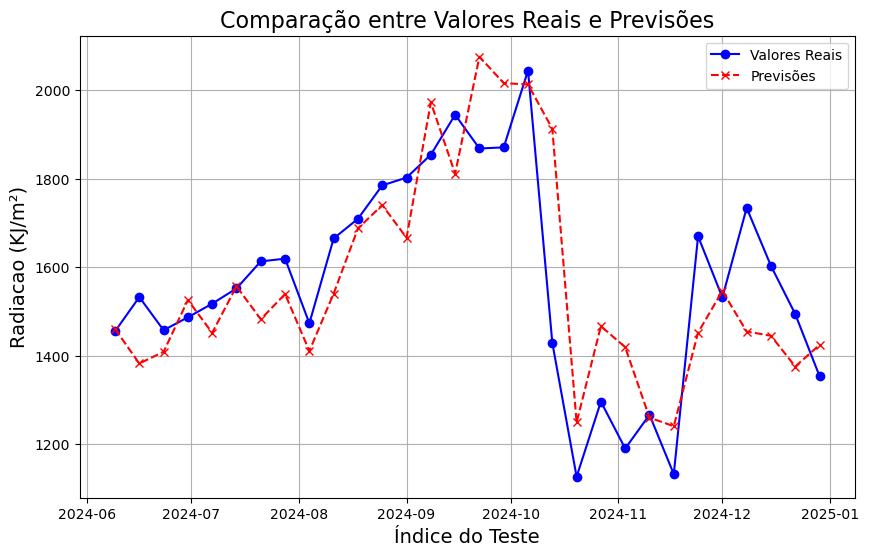

In [28]:
import matplotlib.pyplot as plt

# Supondo que `y_pred` sejam as previsões e `test['Radiacao (KJ/m²)']` seja o valor real

# Plotando as previsões vs os valores reais
plt.figure(figsize=(10, 6))

# Plotando os valores reais (conjunto de teste)

plt.plot(test.index, test['Radiacao (KJ/m²)'], label='Valores Reais', color='blue', linestyle='-', marker='o')

# Plotando as previsões
plt.plot(test.index, y_pred, label='Previsões', color='red', linestyle='--', marker='x')

# Adicionando título e legendas
plt.title('Comparação entre Valores Reais e Previsões', fontsize=16)
plt.xlabel('Índice do Teste', fontsize=14)
plt.ylabel('Radiacao (KJ/m²)', fontsize=14)
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()


<h3>Retreinando os modelos com o dataset completo</h3>

In [41]:
df_reordered.columns

Index(['Temp. Ins. (C)', 'Temp. Max. (C)', 'Temp. Min. (C)', 'Umi. Ins. (%)',
       'Umi. Min. (%)', 'Vel. Vento (m/s)', 'Mes', 'Ano', 'Radiacao (KJ/m²)'],
      dtype='object')

In [42]:
full_data = pd.concat([train, test], axis=0)

# Passo 2: Separar novamente as variáveis explicativas e o target (variável dependente)
X_full = full_data[['Temp. Ins. (C)', 'Temp. Max. (C)', 'Temp. Min. (C)', 'Umi. Ins. (%)',
       'Umi. Min. (%)', 'Vel. Vento (m/s)', 'Mes', 'Ano',]]  # As colunas explicativas
y_full = full_data['Radiacao (KJ/m²)']  # A variável dependente (target)

# Treinar o modelo com os dados completos
# Usando o melhor modelo encontrado no grid search
best_model = grid_search.best_estimator_

# Treinando o modelo com o conjunto completo
best_model.fit(X_full, y_full)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<h3>Previsão em dados futuros (Janeiro de 2025)</h3>

In [44]:
dados_prever = pd.read_csv('jan_2025_xg.csv',index_col='data_hora')

In [45]:
dados_prever.head()

,Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Min. (%),Vel. Vento (m/s),Mes,Ano,Radiacao (KJ/m²)
data_hora,,,,,,,,,
2025-01-05,24.022619,24.807143,23.038095,70.154762,66.119048,2.363095,1,2025,1450.613095
2025-01-12,23.044048,23.679762,22.152381,77.738095,74.619048,2.839286,1,2025,1394.551190
2025-01-19,22.309524,23.066667,21.395238,80.559524,77.023810,2.967857,1,2025,1472.630952
2025-01-26,25.075833,25.806667,23.856667,65.066667,60.933333,2.290000,1,2025,2000.155000


In [50]:
future_exog = dados_prever.iloc[:,0:8]

In [51]:
y_future_pred = best_model.predict(future_exog)

# Exibindo as previsões para o futuro
print("Previsões para os dados futuros:")
print(y_future_pred)

Previsões para os dados futuros:
[1442.7771 1414.1298 1306.4113 1751.0798]


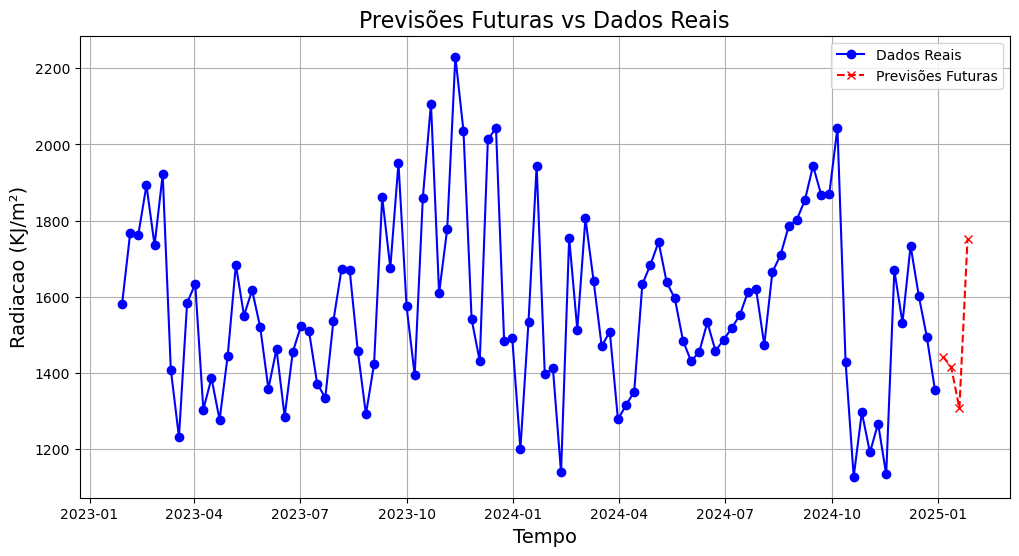

In [57]:
# Passo 1: Concatenar os dados de treino e teste
full_data = pd.concat([train, test], axis=0)

# Passo 3: Plotando os gráficos
plt.figure(figsize=(12, 6))

# Plotando os dados de treinamento e teste (valores reais)
plt.plot(full_data.index, full_data['Radiacao (KJ/m²)'], label='Dados Reais', color='blue', linestyle='-', marker='o')

# Plotando as previsões para o futuro
# Os dados futuros têm um índice contínuo após o último índice de `test`
future_index = pd.date_range(start=test.index[-1], periods=len(y_future_pred) + 1, freq='W')[1:]

plt.plot(future_index, y_future_pred, label='Previsões Futuras', color='red', linestyle='--', marker='x')

# Adicionando título e legendas
plt.title('Previsões Futuras vs Dados Reais', fontsize=16)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Radiacao (KJ/m²)', fontsize=14)
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()


In [69]:
dates = np.array(future_index, dtype='datetime64[D]')
values = np.array(y_future_pred, dtype='float32')

# Usando dtype='object' para criar um array de objetos
combined = np.array([dates, values], dtype=object)

# Criando o DataFrame com tipos misturados
df_previsoes = pd.DataFrame(combined.T, columns=['Data', 'previsao'])

print(df_previsoes)


         Data     previsao
0  2025-01-05    1442.7771
1  2025-01-12  1414.129761
2  2025-01-19  1306.411255
3  2025-01-26  1751.079834


In [70]:
df_previsoes.to_csv('previsoes_radiacao_xg.csv',index=True)

<h3>Comparação entre dados reais e previsão</h3>

In [29]:
#Dados Reais
dados_reais = pd.read_csv('jan_2025_xg.csv',index_col='data_hora')

In [31]:
dados_reais['Radiacao (KJ/m²)'].head()

data_hora
2025-01-05    1450.613095
2025-01-12    1394.551190
2025-01-19    1472.630952
2025-01-26    2000.155000
Name: Radiacao (KJ/m²), dtype: float64

In [33]:
dados_previstos = pd.read_csv('previsoes_radiacao_xg.csv',index_col='Data')

In [35]:
dados_previstos['previsao'].head()

Data
2025-01-05    1442.777100
2025-01-12    1414.129761
2025-01-19    1306.411255
2025-01-26    1751.079834
Name: previsao, dtype: float64

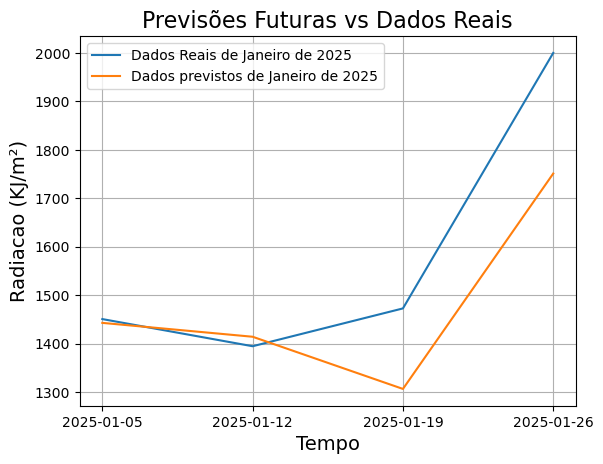

In [39]:
plt.plot(dados_reais['Radiacao (KJ/m²)'],label='Dados Reais de Janeiro de 2025')
plt.plot(dados_previstos['previsao'],label='Dados previstos de Janeiro de 2025')
plt.title('Previsões Futuras vs Dados Reais', fontsize=16)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Radiacao (KJ/m²)', fontsize=14)
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()